<a href="https://colab.research.google.com/github/Vignesh-397/Image_Captioning/blob/main/Image_Captioning_Custom_Dataset_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [3]:
# Setting the input and output directory
INPUT_DIR = '/content/drive/MyDrive/Major Project 2024/Dataset/Custom_Dataset'
OUTPUT_DIR = '/content/drive/MyDrive/Major Project 2024/Dataset/Custom_Dataset/v1_outputs'

In [4]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/330 [00:00<?, ?it/s]

In [6]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [7]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [8]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [9]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/987 [00:00<?, ?it/s]

Total number of captions: 986


In [10]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
image_to_captions_mapping['002']

['A black circular sports watch with a smooth round face  black straps and white minute and hour hands',
 'A black sports watch with a circular dial and white hour and minute hands',
 'A black circular sports watch with a smooth round face  black straps and white minute and hour hands']

In [12]:
# preprocess the text
clean(image_to_captions_mapping)

In [13]:
# after preprocess of text
image_to_captions_mapping['002']

['startseq black circular sports watch with smooth round face black straps and white minute and hour hands endseq',
 'startseq black sports watch with circular dial and white hour and minute hands endseq',
 'startseq black circular sports watch with smooth round face black straps and white minute and hour hands endseq']

In [14]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [15]:
all_captions[:10]

['startseq black circular sports watch with smooth round face black straps and white minute and hour hands endseq',
 'startseq circular black watch with black strap and white hour and minute hands endseq',
 'startseq black circular sports watch with smooth round face black straps and white minute and hour hands endseq',
 'startseq black sports watch with circular dial and white hour and minute hands endseq',
 'startseq black circular sports watch with smooth round face black straps and white minute and hour hands endseq',
 'startseq black sports watch with circular dial and white hour and minute hands endseq',
 'startseq black circular sports watch with smooth round face black straps and white minute and hour hands endseq',
 'startseq black circular sports watch with smooth round face black straps and white minute and hour hands endseq',
 'startseq rectangular fullframe spectacle with transparent body endseq',
 'startseq transparent rectangular fullframe spectacle with clear lens endse

In [16]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [17]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [18]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 428
Maximum Caption Length: 18


In [19]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [93]:
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys:
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    # Changed padding to 'post' to right pad the sequences
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        # yield ([X1_batch, X2_batch], y_batch) # Old yield statement

                        # New yield statement using tf.data.Dataset.from_generator
                        # The function expects a single argument therefore combine X1 and X2
                        # and specify the type and shape for from_generator

                        # Changed the keys to match the input layer names
                        yield ({'input_layer_11':X1_batch, 'input_layer_12': X2_batch}, y_batch)
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

In [26]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.0 MB/s eta 0:00:00


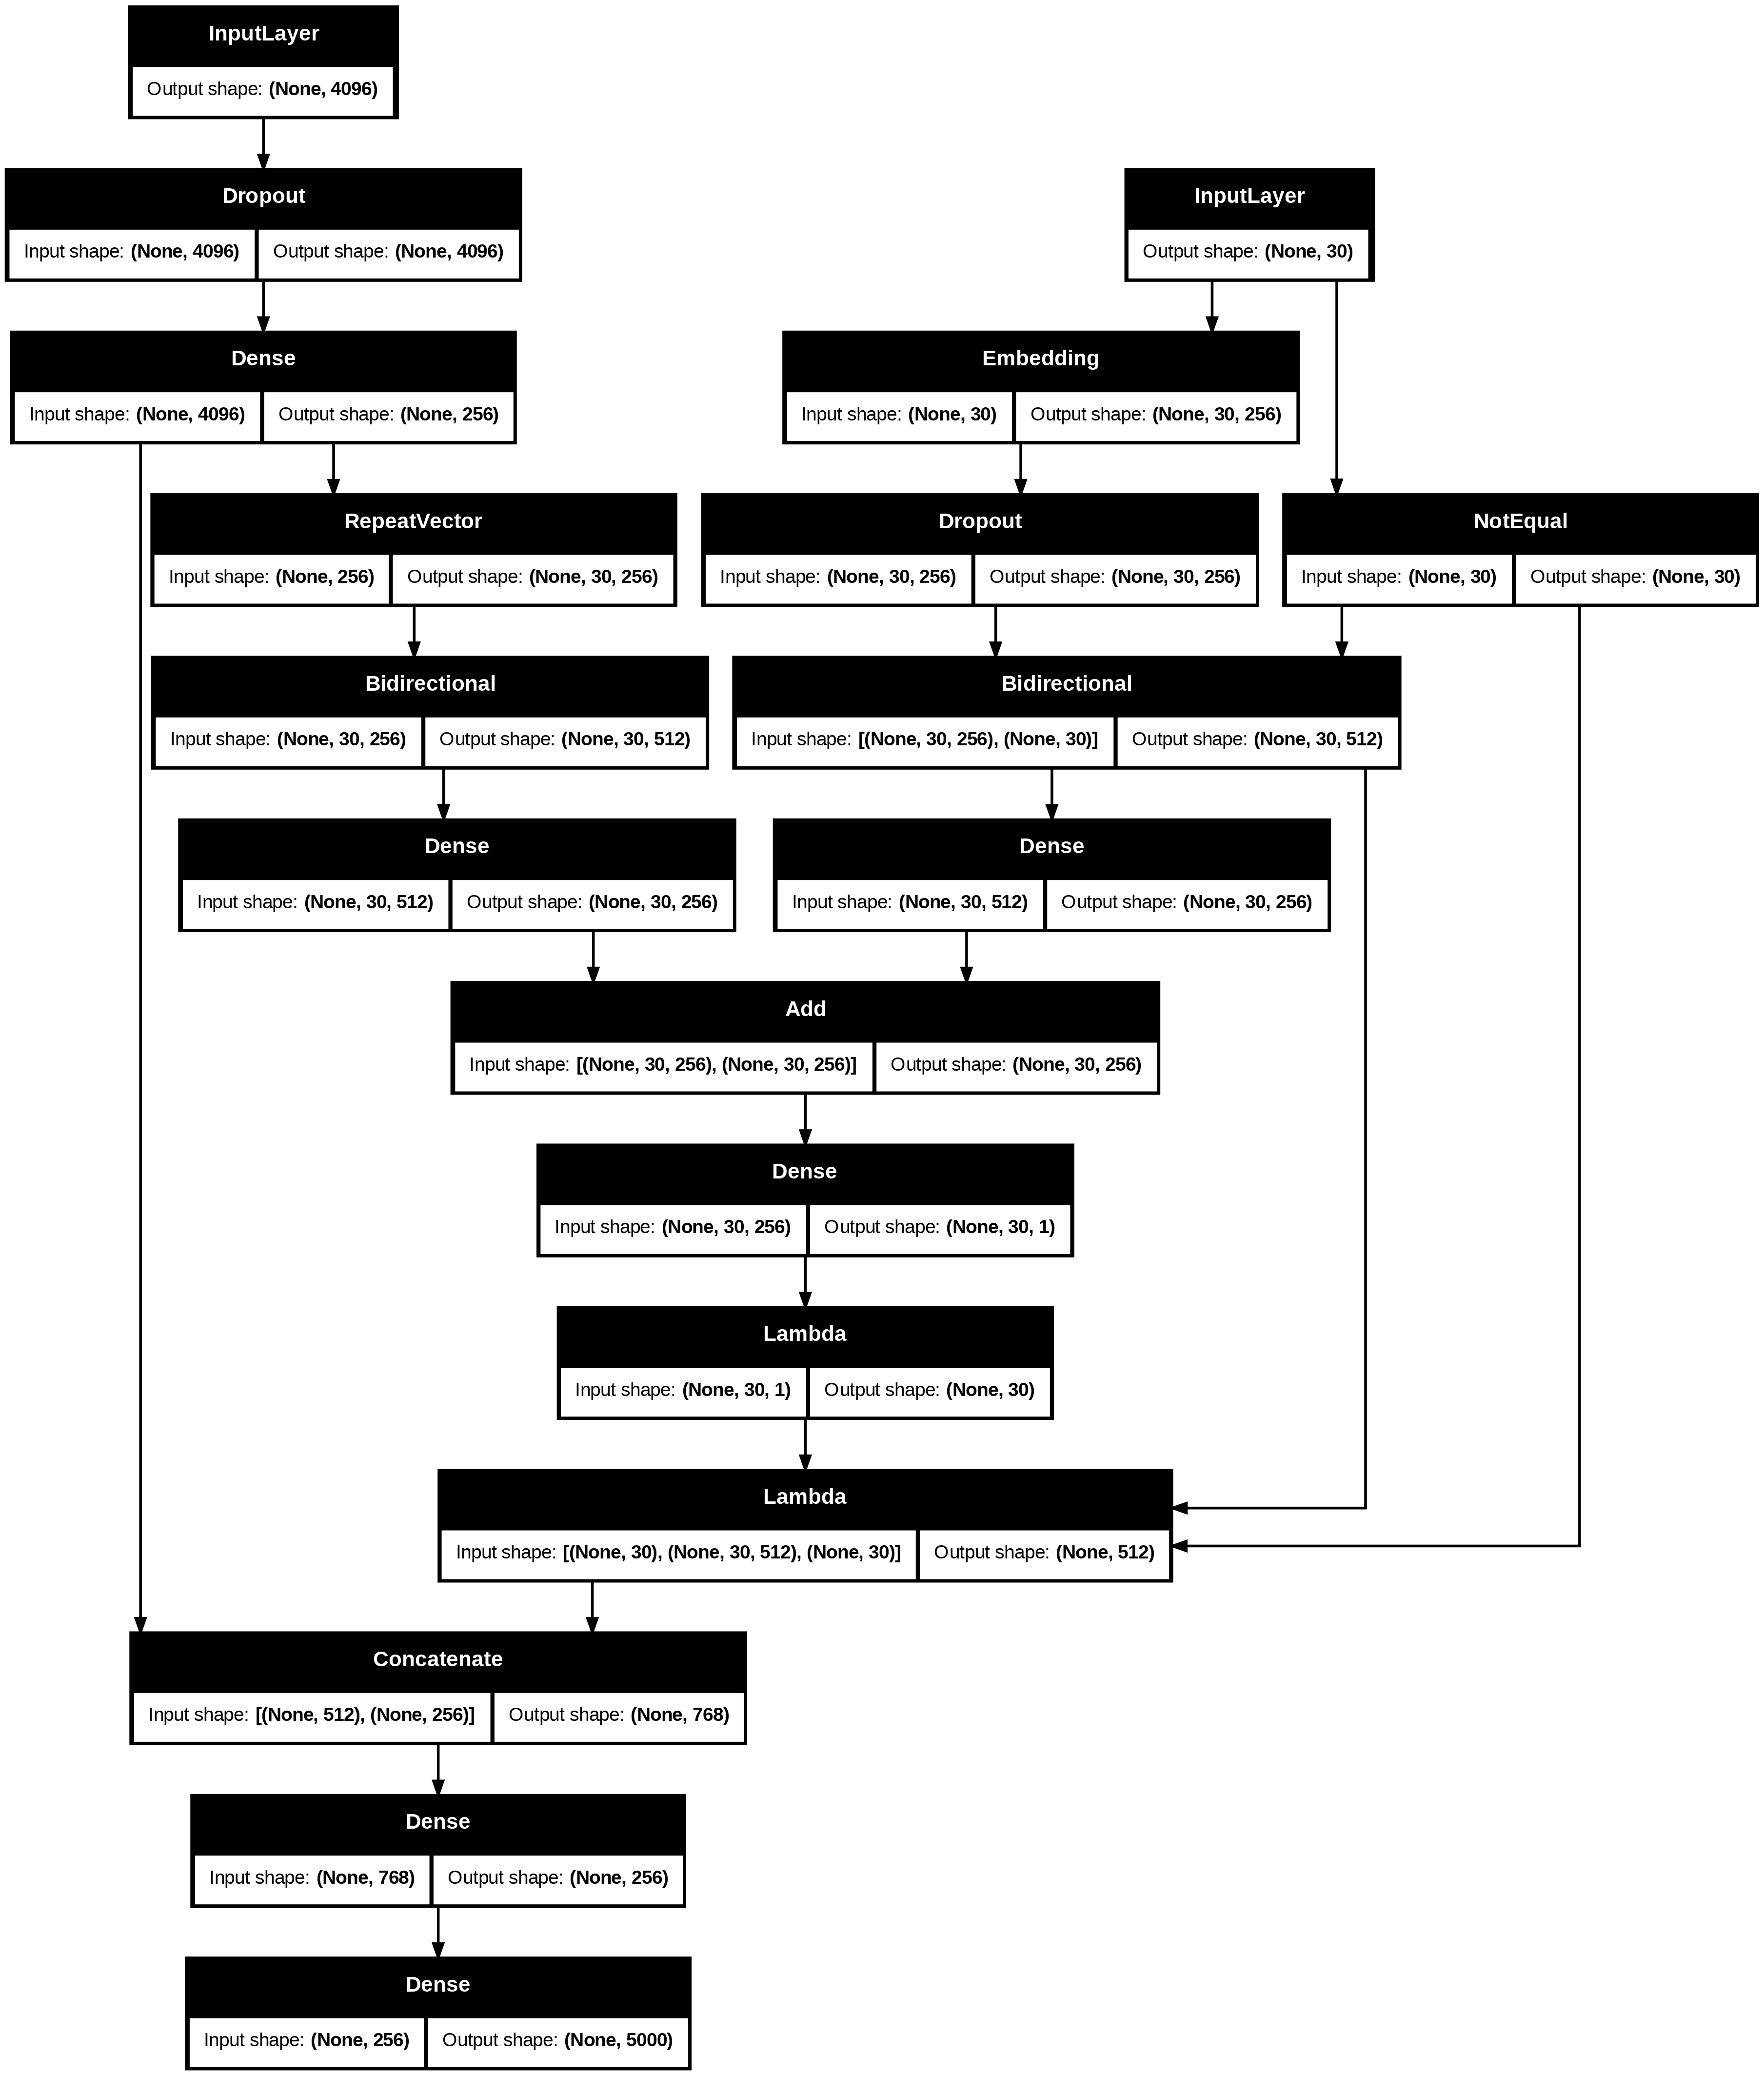

In [94]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import Loss
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda, Add # Importing the 'Add' layer

# Define Cosine Annealing schedule
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=5e-4,
    first_decay_steps=1000,  # Adjust based on dataset size and training iterations
    t_mul=2.0,               # Factor to increase cycle length
    m_mul=0.9,               # Factor to decrease max learning rate
    alpha=0.0                # Minimum learning rate as a fraction of initial_learning_rate
)

# Updated optimizer with cosine annealing
optimizer = Adam(learning_rate=lr_schedule)

# Encoder model
inputs1 = Input(shape=(4096,), name='input_layer_11')  # Assign name 'input_layer_11'
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(fe1)  # Added L2 regularization
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,), name='input_layer_12')  # Assign name 'input_layer_12'
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Bahdanau Attention Mechanism
attention_dense1 = Dense(256, activation='tanh')(fe2_projected)  # Project encoder features
attention_dense2 = Dense(256, activation='tanh')(se3)  # Project decoder sequence
attention_combined = Add()([attention_dense1, attention_dense2])  # Combine projected features
attention_score = Dense(1, activation='softmax')(attention_combined)  # Compute attention scores

# Reshape attention scores and apply to sequence embeddings
attention_weights = Lambda(lambda x: tf.squeeze(x, axis=-1))(attention_score)  # Squeeze last dimension
attention_context = Lambda(lambda x: tf.einsum('ij,ijk->ik', x[0], x[1]))([attention_weights, se3])

# Decoder model
decoder_input = concatenate([attention_context, fe2], axis=-1)
decoder1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(decoder_input)  # Added L2 regularization
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model with custom loss
# loss_fn = SparseCategoricalCrossentropy(from_logits=False)  # Set `from_logits=True` if your output layer does not have activation

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Visualize the model
plot_model(model, show_shapes=True)

In [95]:
# To store metrics for plotting
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Set the number of epochs, batch size
epochs = 100
batch_size = 64

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)

    history = model.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_generator,
        validation_steps=validation_steps,
        verbose=1
    )

    # Append metrics for visualization
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_acc.append(history.history['accuracy'][0])
    val_acc.append(history.history['val_accuracy'][0])

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.0125 - loss: 16.8142 - val_accuracy: 0.1406 - val_loss: 15.5331
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1211 - loss: 14.2117 - val_accuracy: 0.1875 - val_loss: 12.8674
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0961 - loss: 11.1119 - val_accuracy: 0.0625 - val_loss: 12.5925
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1283 - loss: 9.7279 - val_accuracy: 0.1875 - val_loss: 12.3352
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1293 - loss: 8.7840 - val_accuracy: 0.1875 - val_loss: 11.8030
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1563 - loss: 8.2260 - val_accuracy: 0.1875 - val_loss: 11.2902
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2191 - loss: 7.5393 - val_accuracy: 0.1719 - val_loss: 10.9783
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1908 - loss: 7.0154 - val_accuracy: 0.1875 

KeyboardInterrupt: 

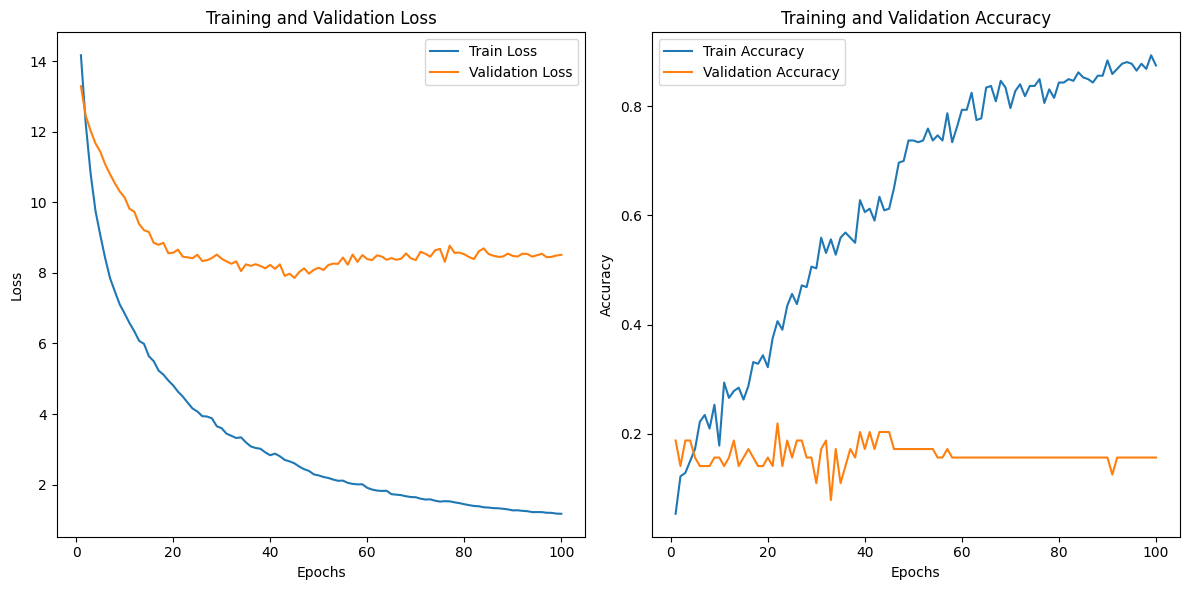

In [61]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Save the model
model.save(OUTPUT_DIR+'/image_captioning_model_v1.h5')

In [63]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [64]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'

    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length, ensuring right padding
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')  # Changed padding to 'post'
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        # Append the predicted word to the caption
        caption += " " + predicted_word

        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break

    return caption

In [65]:
!pip install rouge-score
!pip install nltk
import nltk
nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=4e0050927a6bdea18fd1a2f181cd1e8bf14032e603ca42209706f2f8a0fec3b7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [67]:
# Required Imports
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from collections import defaultdict
import pandas as pd

# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Metrics storage
meteor_scores = []
rouge_scores = defaultdict(list)
cider_scorer = Cider()
spice_scorer = Spice()

# Variables to store SPICE and CIDEr scores
cider_scores = []
spice_scores = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]  # Tokenize actual captions
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

    # Calculate METEOR
    meteor_scores.append(
        max([meteor_score([caption.split()], predicted_caption.split()) for caption in actual_captions])
    )
    # Calculate ROUGE
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    for caption in actual_captions:
        scores = scorer.score(caption, predicted_caption)
        for metric, score in scores.items():
            rouge_scores[metric].append(score.fmeasure)

    # Prepare CIDEr and SPICE evaluation inputs
    # Create dictionaries for scorers: {image_id: [caption]}
    actual_dict = {0: actual_captions}
    predicted_dict = {0: [predicted_caption]}

    # Calculate CIDEr and SPICE scores
    cider_score, _ = cider_scorer.compute_score(actual_dict, predicted_dict)
    spice_score, _ = spice_scorer.compute_score(actual_dict, predicted_dict)
    cider_scores.append(cider_score)
    spice_scores.append(spice_score)

# Calculate BLEU scores
bleu1 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.25, 0.25, 0.25, 0.25))

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge_scores["rouge1"]) / len(rouge_scores["rouge1"])
avg_rouge2 = sum(rouge_scores["rouge2"]) / len(rouge_scores["rouge2"])
avg_rougeL = sum(rouge_scores["rougeL"]) / len(rouge_scores["rougeL"])

# Calculate average CIDEr and SPICE scores
avg_cider = sum(cider_scores) / len(cider_scores)
avg_spice = sum(spice_scores) / len(spice_scores)

# Create table
metrics_table = pd.DataFrame({
    "Metric": ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "METEOR", "ROUGE-1", "ROUGE-2", "ROUGE-L", "CIDEr", "SPICE"],
    "Score": [
        bleu1,
        bleu2,
        bleu3,
        bleu4,
        sum(meteor_scores) / len(meteor_scores),
        avg_rouge1,
        avg_rouge2,
        avg_rougeL,
        avg_cider,
        avg_spice,
    ]
})

# Print table
print("\n")
print(metrics_table.to_markdown(index=False))


100%|██████████| 33/33 [05:38<00:00, 10.26s/it]



| Metric   |     Score |
|:---------|----------:|
| BLEU-1   | 0.488038  |
| BLEU-2   | 0.210635  |
| BLEU-3   | 0.0874197 |
| BLEU-4   | 0.048735  |
| METEOR   | 0.341598  |
| ROUGE-1  | 0.442226  |
| ROUGE-2  | 0.0610355 |
| ROUGE-L  | 0.439521  |
| CIDEr    | 0         |
| SPICE    | 0.211169  |


In [70]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq blackcolored logitech mouse endseq
startseq logitech black mouse endseq
startseq logitech mouse in black color endseq
--------------------Predicted--------------------
startseq black watch with black strap endseq


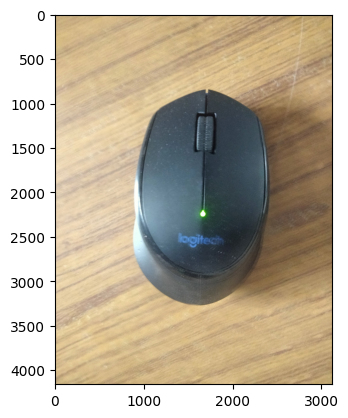

In [73]:
generate_caption("026.jpg")

##**Caption Generation For Unseen Image**

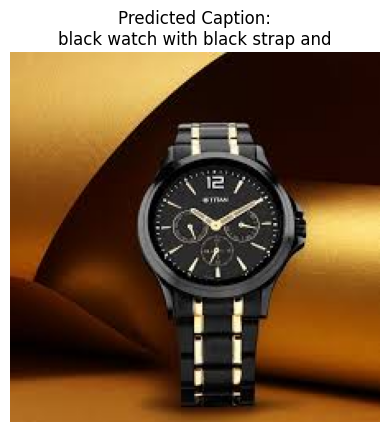

In [74]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model_1 = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model_1 = Model(inputs=model_1.inputs, outputs=model_1.layers[-2].output)


def generate_caption_for_new_image(image_path):
    # Load and preprocess the new image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features using the pre-trained ResNet50 model
    image_features = model_1.predict(image, verbose=0)  # Replace 'model' with 'feature_extraction_model'

    # Generate caption
    caption = 'startseq'
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding='post')

        # Predict the next word
        yhat = model.predict([image_features, sequence], verbose=0)  # Use the caption generation model
        predicted_index = np.argmax(yhat)
        predicted_word = get_word_from_index(predicted_index, tokenizer)

        if predicted_word is None or predicted_word == 'endseq':
            break
        caption += ' ' + predicted_word

    # Remove startseq and endseq for readability
    caption = caption.replace('startseq', '').replace('endseq', '').strip()

    # Display the image and its caption
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted Caption:\n" + caption)
    plt.show()

# Example usage:
new_image_path = 'download.jpeg'  # Replace with your image path
generate_caption_for_new_image(new_image_path)
